In [1]:
# import
import torch
# import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim

# plt settings
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def initialize(segment):
    # x_vec = torch.linspace(-torch.pi, torch.pi, segment)
    p_vec = torch.randn(segment) * 0.1
    p_vec.requires_grad = True
    return p_vec

In [3]:
# # for debug 
# fig, ax = plt.subplots()
# ax.plot(x_vec)
# print(p_vec)

In [4]:
def exp_then_FT(p_vec):
    """exp p_vec to get modulated field, then do FFT to get coefficience of each order

    Args:
        p_vec (tenser): phase of the gating indroduce

    Returns:
        tenser: fourier coefficiency, shape of p_vec
    """

    exp_p = torch.exp(1j * p_vec) # p_vec do not need to use torch.complex64
    # question: if p_vec use torch.complex64, will autograd compute imagine part
    # return exp_p
    return torch.fft.fft(exp_p)/len(exp_p)

In [5]:
# # test exp_then_FT
# # coefficience = exp_then_FT(-1j * torch.log(torch.cos(x_vec) + 2), x_vec)
# # coefficience = exp_then_FT(x_vec, x_vec)
# # coefficience = exp_then_FT(p_vec, x_vec)
# coefficience = exp_then_FT(torch.randn(10000))

# plt.stem(torch.abs(coefficience).detach().numpy())
# # test energy conserve 
# frequency_energy = torch.sum(torch.abs(coefficience) ** 2).item()
# phase_energy = torch.sum(torch.abs(torch.exp(p_vec)) ** 2).item()
# print("energy of frequncy domain", frequency_energy)
# print("energy of phase domain", phase_energy)

# print("coefficience 0: ", coefficience[0])
# print("coefficience -1: ", coefficience[-1])
# print("coefficience 1: ", coefficience[1])


In [6]:
def forward(p_vec: torch.tensor, alpha=0.5):
    # return loss
    loss = 0

    coefficient = exp_then_FT(p_vec)
    total_energy = 1 # phase domian magnitude is all 1, energy conserve
    minus1_energy = torch.abs(coefficient[-1])**2  
    plus1_energy = torch.abs(coefficient[1])**2  
    want_energy = minus1_energy + plus1_energy
    energy_efficiency = want_energy / total_energy
    
    loss += (alpha) * (1 - energy_efficiency)
    loss += (1 - alpha) * torch.abs(minus1_energy - plus1_energy)
    
    return loss
    

In [7]:
# # test forward
# random_vec = torch.randn(10000)
# loss = forward(random_vec).item()
# print("loss", loss)
# coefficience = exp_then_FT(random_vec)

# plt.stem(torch.abs(coefficience).detach().numpy())
# # test energy conserve 
# frequency_energy = torch.sum(torch.abs(coefficience) ** 2).item()
# phase_energy = torch.sum(torch.abs(torch.exp(p_vec)) ** 2).item()
# print("energy of frequncy domain", frequency_energy)
# print("energy of phase domain", phase_energy)

# print("coefficience 0: ", coefficience[0])
# print("coefficience -1: ", coefficience[-1])
# print("coefficience 1: ", coefficience[1])

In [19]:
def visualize(p_vec):
    coefficient = exp_then_FT(p_vec)

    plt.subplot(1, 2, 1)
    plt.stem(p_vec.detach().numpy())
    plt.title('phase function')

    plt.subplot(1, 2, 2)
    plt.stem(torch.abs(coefficient).detach().numpy())
    plt.title('Fourier coefficient')

    # test energy conserve 
    frequency_energy = torch.sum(torch.abs(coefficient) ** 2).item()
    # phase_energy = torch.sum(torch.abs(torch.exp(p_vec)) ** 2).item()
    print("energy of frequncy domain", frequency_energy)
    # print("energy of phase domain", phase_energy)

    print("Calculate Energy Efficiency:")
    print("Energy Efficiency =",(abs(coefficient[1])**2).item()+(abs(coefficient[-1])**2).item())
    print("\n")

    # print("coefficience 0: ", coefficient[0])
    # print("coefficience -1: ", coefficient[-1])
    # print("coefficience 1: ", coefficient[1])

    # print("energy of order 1:", )
    print("Some Fourier Coefficients:")
    coeff_indices = [0, -1, 1, -2, 2, -3, 3, -4, 4]
    for index in coeff_indices:
        coeff_value = coefficient[index]
        magnitude = torch.abs(coeff_value).detach().item()
        # magnitude_squared = magnitude ** 2
        print(f"coefficient {index}: {coeff_value}, Magnitude: {magnitude}")
    print("\n")


In [9]:
# use momentum SGD
def train(epoches=10000, learning_rate=1e1, alpha=0.5, segment=10000, momentum=0.9, verbose=False):
    p_vec = initialize(segment)
    optimizer = optim.SGD([p_vec], lr=learning_rate, momentum=momentum)
    loss_history = []
    for epoch in range(epoches):
        optimizer.zero_grad()
        loss = forward(p_vec, alpha)
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())
        if verbose:
            print('Epoch:', epoch, 'Loss:', loss.item())

    if verbose:    
        plt.plot(loss_history, label='loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
    
    return p_vec, loss_history

Epoch: 0 Loss: 0.7999967932701111
Epoch: 1 Loss: 0.7999967932701111
Epoch: 2 Loss: 0.7999967932701111
Epoch: 3 Loss: 0.7999967336654663
Epoch: 4 Loss: 0.7999967336654663
Epoch: 5 Loss: 0.7999966740608215
Epoch: 6 Loss: 0.7999966144561768
Epoch: 7 Loss: 0.799996554851532
Epoch: 8 Loss: 0.799996554851532
Epoch: 9 Loss: 0.7999964952468872
Epoch: 10 Loss: 0.7999964356422424
Epoch: 11 Loss: 0.7999963760375977
Epoch: 12 Loss: 0.7999963164329529
Epoch: 13 Loss: 0.7999963164329529
Epoch: 14 Loss: 0.7999962568283081
Epoch: 15 Loss: 0.7999961972236633
Epoch: 16 Loss: 0.7999961376190186
Epoch: 17 Loss: 0.7999960780143738
Epoch: 18 Loss: 0.799996018409729
Epoch: 19 Loss: 0.7999959588050842
Epoch: 20 Loss: 0.7999958992004395
Epoch: 21 Loss: 0.7999958395957947
Epoch: 22 Loss: 0.7999957799911499
Epoch: 23 Loss: 0.7999957203865051
Epoch: 24 Loss: 0.7999956011772156
Epoch: 25 Loss: 0.7999956011772156
Epoch: 26 Loss: 0.799995481967926
Epoch: 27 Loss: 0.7999954223632812
Epoch: 28 Loss: 0.7999953627586365

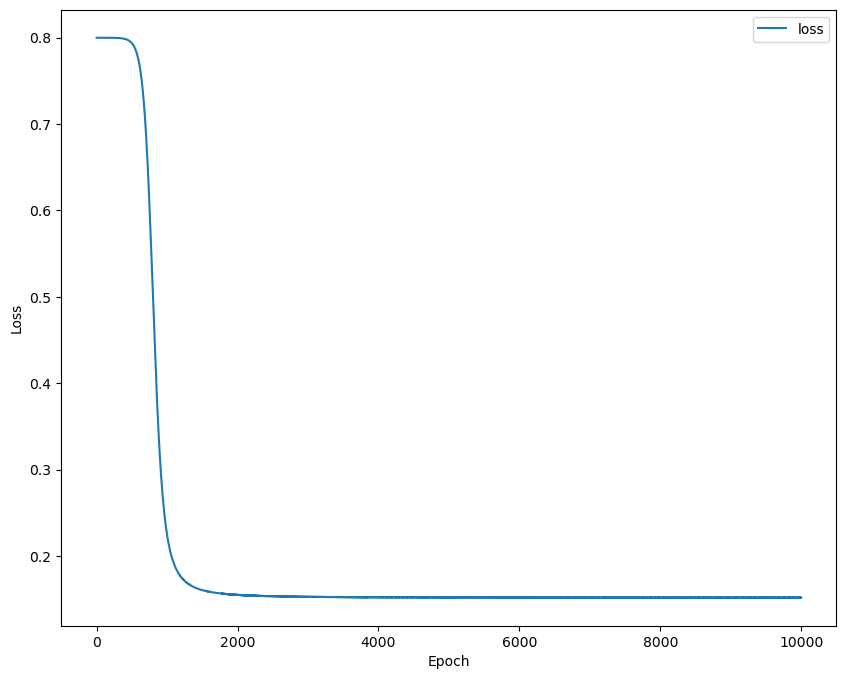

In [17]:
p_vec, loss_history = train(
    10000,
    1e1,
    0.8, 
    10000,
    0.8,
    True,
)

energy of frequncy domain 0.9999998807907104
Calculate Energy Efficiency:
Energy Efficiency = 0.8104938268661499


Some Fourier Coefficients:
coefficient 0: (0.010597499087452888+4.8717341996962205e-05j), Magnitude: 0.010597610846161842
coefficient -1: (0.34883734583854675-0.5326442122459412j), Magnitude: 0.6367081999778748
coefficient 1: (-0.3495369851589203-0.5319026112556458j), Magnitude: 0.6364719271659851
coefficient -2: (-0.004170669242739677-0.009736335836350918j), Magnitude: 0.010592011734843254
coefficient 2: (-0.004259800538420677+0.009696963243186474j), Magnitude: 0.010591364465653896
coefficient -3: (-0.2090470939874649-0.03593513369560242j), Magnitude: 0.21211323142051697
coefficient 3: (0.20899967849254608-0.03626054897904396j), Magnitude: 0.2121218889951706
coefficient -4: (-0.007260321173816919+0.007688294630497694j), Magnitude: 0.010574598796665668
coefficient 4: (-0.007188279181718826-0.007753930054605007j), Magnitude: 0.010573305189609528




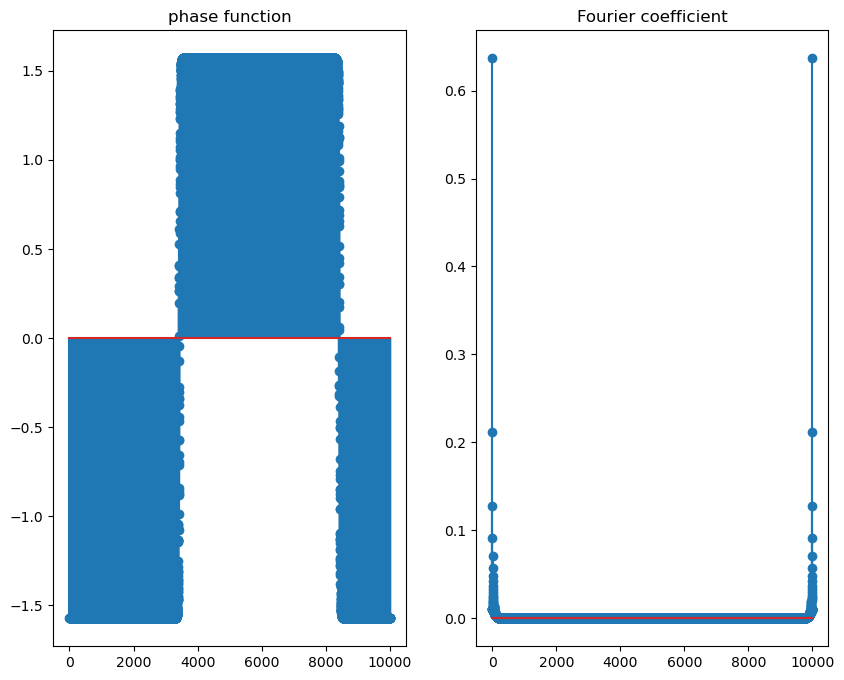

In [20]:
visualize(p_vec)

In [21]:
result = {} # {alpha: [energy efficiency, p_vec], ...}

alpha_list = torch.linspace(0, 1, 11)

for alpha in alpha_list:
    p_vec, loss_history = train(
        10000,
        1e1,
        alpha, 
        10000,
        0.8,
        False,
    )
    coefficient = exp_then_FT(p_vec)
    minus1_energy = torch.abs(coefficient[-1])**2  
    plus1_energy = torch.abs(coefficient[1])**2  
    want_energy = minus1_energy + plus1_energy
    energy_efficiency = want_energy / 1
    result[alpha] = [energy_efficiency.item(), p_vec]

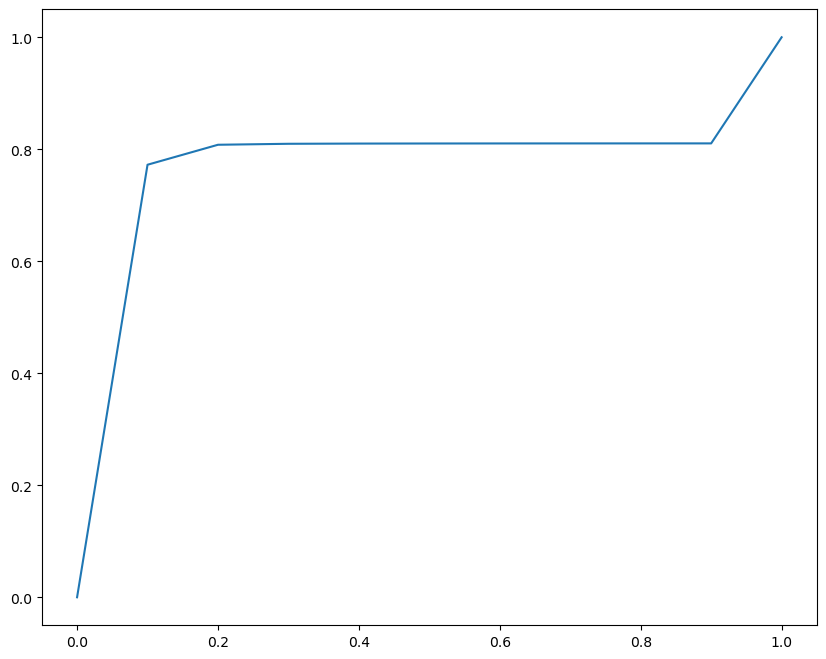

In [23]:
# plot the energy efficiency

plt.plot(result.keys(), [value[0] for value in result.values()])

energy of frequncy domain 1.000000238418579
Calculate Energy Efficiency:
Energy Efficiency = 0.8104664981365204


Some Fourier Coefficients:
coefficient 0: (0.012378865852952003+0.00013995470362715423j), Magnitude: 0.012379656545817852
coefficient -1: (-0.6158921122550964+0.16023938357830048j), Magnitude: 0.6363959312438965
coefficient 1: (0.6162352561950684+0.1603771448135376j), Magnitude: 0.6367626786231995
coefficient -2: (0.010870610363781452-0.005903829820454121j), Magnitude: 0.012370342388749123
coefficient 2: (0.010734053328633308+0.006148147396743298j), Magnitude: 0.012370109558105469
coefficient -3: (-0.15319189429283142+0.14667363464832306j), Magnitude: 0.21208703517913818
coefficient 3: (0.1531772017478943+0.14668352901935577j), Magnitude: 0.21208326518535614
coefficient -4: (0.006602456793189049-0.01042777206748724j), Magnitude: 0.012342238798737526
coefficient 4: (0.006364101078361273+0.010574385523796082j), Magnitude: 0.012341775000095367




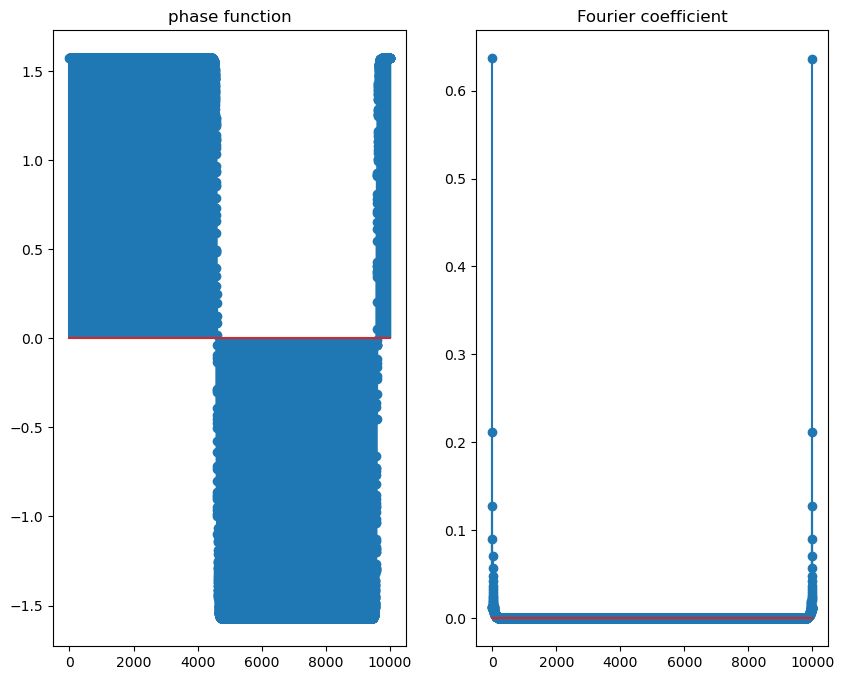

In [49]:

i = 0
which = 7
for value in result.values():
    if i == which:
        visualize(value[1])
    i += 1